[![Open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Its-Shivanshu-Sharma/AdversarialAttacks/blob/main/Adversarial_Attacks.ipynb)

# Adversarial Attacks on Neural Networks

---

## Table of Contents:
- ### [Installing & Importing packages, libraries, etc](#installing-&-importing-packages,-libraries,-etc)
- ### [Fetching & preparing the Dataset](#fetching-&-preparing-the-dataset)

<a name="installing-&-importing-packages,-libraries,-etc"></a>

---
## Installing & Importing packages, libraries, etc

### Installing packages

In [1]:
%%bash
pip3 install -qq torch==1.10.2+cu113 torchvision==0.11.3+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

tcmalloc: large alloc 1147494400 bytes == 0x55cc0e902000 @  0x7f87817b7615 0x55cbd5c2b3bc 0x55cbd5d0c18a 0x55cbd5c2e1cd 0x55cbd5d20b3d 0x55cbd5ca2458 0x55cbd5c9d02f 0x55cbd5c2faba 0x55cbd5ca22c0 0x55cbd5c9d02f 0x55cbd5c2faba 0x55cbd5c9ecd4 0x55cbd5d21986 0x55cbd5c9e350 0x55cbd5d21986 0x55cbd5c9e350 0x55cbd5d21986 0x55cbd5c9e350 0x55cbd5c2ff19 0x55cbd5c73a79 0x55cbd5c2eb32 0x55cbd5ca21dd 0x55cbd5c9d02f 0x55cbd5c2faba 0x55cbd5c9ecd4 0x55cbd5c9d02f 0x55cbd5c2faba 0x55cbd5c9deae 0x55cbd5c2f9da 0x55cbd5c9e108 0x55cbd5c9d02f
tcmalloc: large alloc 1434370048 bytes == 0x55cc52f58000 @  0x7f87817b7615 0x55cbd5c2b3bc 0x55cbd5d0c18a 0x55cbd5c2e1cd 0x55cbd5d20b3d 0x55cbd5ca2458 0x55cbd5c9d02f 0x55cbd5c2faba 0x55cbd5ca22c0 0x55cbd5c9d02f 0x55cbd5c2faba 0x55cbd5c9ecd4 0x55cbd5d21986 0x55cbd5c9e350 0x55cbd5d21986 0x55cbd5c9e350 0x55cbd5d21986 0x55cbd5c9e350 0x55cbd5c2ff19 0x55cbd5c73a79 0x55cbd5c2eb32 0x55cbd5ca21dd 0x55cbd5c9d02f 0x55cbd5c2faba 0x55cbd5c9ecd4 0x55cbd5c9d02f 0x55cbd5c2faba 0x55cbd5c9

### Importing packages, libraries, etc

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [3]:
# Setting setting the seed for the RNG (Random Number Generator)
# for reproducibility
torch.manual_seed(1234)

<a name="fetching-&-preparing-the-dataset"></a>

---
## Fetching & preparing the Dataset

We'll creating a model for binary classification using the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/).

In [4]:
%%bash
# Create a new directory to store the dataset
mkdir pets_dataset
cd pets_dataset
wget -q https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
wget -q https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
tar -xf images.tar.gz
tar -xf annotations.tar.gz

In [5]:
from pathlib import Path

In [6]:
path = Path("/content/pets_dataset")

In [7]:
def ls(path):
    for f in path.iterdir():
        print(f"{'d' if f.is_dir() else 'f': <4}{f}")

In [8]:
ls(path)

d   /content/pets_dataset/annotations
d   /content/pets_dataset/images
f   /content/pets_dataset/annotations.tar.gz
f   /content/pets_dataset/images.tar.gz


In [9]:
import pandas as pd

In [10]:
df = pd.read_csv(
    path / "annotations" / "list.txt",
    skiprows=6,
    header=None,
    names=["file_name", "class_id", "species", "breed_id"],
    sep=" ",
)
df.head()

,file_name,class_id,species,breed_id
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [11]:
df = df.loc[:, ["file_name", "species"]]
df.head()

,file_name,species
0,Abyssinian_100,1
1,Abyssinian_101,1
2,Abyssinian_102,1
3,Abyssinian_103,1
4,Abyssinian_104,1


#### Change the labels (i.e. `species`) such that:
`Cat = 0` & `Dog = 1`

In [12]:
new_label_map = {
    1: 0,
    2: 1,
}

In [13]:
df.loc[:, "species"] = df.loc[:, "species"].apply(new_label_map.get)

In [14]:
df.head()

,file_name,species
0,Abyssinian_100,0
1,Abyssinian_101,0
2,Abyssinian_102,0
3,Abyssinian_103,0
4,Abyssinian_104,0


In [15]:
def train_val_split(data, train_sz=None, val_sz=None):
    """Function to randomly split data into training & validation sets
    Parameters:
        data (pandas.DataFrame) - dataframe containing the annotations for the
                                    images
        train_sz (float) - fraction of data to be allocated to training set
        val_sz (float) - fraction of data to be allocated to test set
                            (`test_sz` is ignored if `train_sz` is not `None`)

    Returns:
        A tuple containing Dataframes for the training and validation sets,
        i.e. returns `(train_set, val_set)`.
    """
    size = len(data)
    # Calculate length of the training set
    if train_sz:
        train_len = int(train_sz * size)
    elif val_sz:
        train_len = size - int(val_sz * size)

    # Randomly generate training and validation datasets
    idxs = torch.randperm(size)
    train_set = data.iloc[idxs[:train_len], :].reset_index(drop=True)
    val_set = data.iloc[idxs[train_len:], :].reset_index(drop=True)

    return train_set, val_set

In [16]:
train_set, val_set = train_val_split(df, train_sz=0.8)

In [17]:
train_set.head()

,file_name,species
0,staffordshire_bull_terrier_174,1
1,beagle_73,1
2,Abyssinian_192,0
3,american_pit_bull_terrier_93,1
4,american_pit_bull_terrier_119,1


#### Create `Dataset` objects for the training & validations sets

In [18]:
import os

from torchvision.io import read_image
from torchvision.transforms import Resize

In [19]:
class PetsDataset(Dataset):
    """Custom defined Dataset subclass for working with the IIIT-Pets Dataset"""

    def __init__(
        self,
        annotations,
        img_dir,
        img_format="jpg",
        transform=None,
        target_transform=None,
    ):
        """Parameters:
        annotations (pandas.DataFrame) - dataframe containing the annotations
        img_dir (str or Path object) - path to directory containing images
        img_format (str: default = 'jpg') - format of the images
        transform (callable; optional) - Tranformation to apply to images
        target_transform (callable; optional) - Transformation to apply to
                                                target labels
        """
        self.annotations = annotations
        self.img_dir = img_dir
        self.img_format = img_format
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        file_name = self.annotations.iloc[index, 0] + "." + self.img_format
        img_file = os.path.join(self.img_dir, file_name)
        image = read_image(img_file)
        label = self.annotations.iloc[index, 1]

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### **Note:** Some images have an additional `alpha` channel for transparency.<br>This will cause problems, hence, we will simply remove this additional channel using the `resize_remove` tranform on the images.

In [20]:
def resize_remove(img_size):
    """This function will resize the image to the passed size using `torchvision.transforms.Resize`
    and will keep only the first `img_size[0]` number of channels.

    Parameters:
        img_size (tuple or array-like) - specifies the size
                                        (channels, height, width) to which the
                                        image must be resized
    Returns:
        a callable that will resize the image & remove extra channels
    """
    resizer = Resize(img_size[1:])

    def transform(img):
        return resizer(img[: img_size[0], :, :])

    return transform

In [21]:
# Define the image size in (C, H, W) format
img_size = (3, 150, 150)

In [22]:
train_data = PetsDataset(
    train_set, img_dir=path / "images", transform=resize_remove(img_size)
)
val_data = PetsDataset(
    val_set, img_dir=path / "images", transform=resize_remove(img_size)
)

### Visualizing the Data

In [23]:
import matplotlib.pyplot as plt

In [24]:
def viz_data(data, label_map, n_rows=3, n_cols=3):
    """Function to display n_rows*n_cols number of images of the Dataset
    Parameters:
        data (Dataset or its subclass) - data which has to be visualized
        label_map (dict) - mapping from int to labels for the classes
        n_rows (int) - no. of rows of images to display
        n_cols (int) - no. of columns of images to display
    """
    figure = plt.figure(figsize=(8, 8))
    # Randomly choose the images to display from the data
    idxs = torch.randint(high=len(data), size=(n_rows * n_cols,)).tolist()

    for i, idx in enumerate(idxs):
        img, label = data[idx]
        figure.add_subplot(n_rows, n_cols, i + 1)
        plt.title(label_map.get(label))
        plt.axis("off")
        plt.imshow(img.permute((1, 2, 0)))  # change image to (H,W,C) format
    plt.show()

In [59]:
species_map = {
    0: "Cat",
    1: "Dog",
}

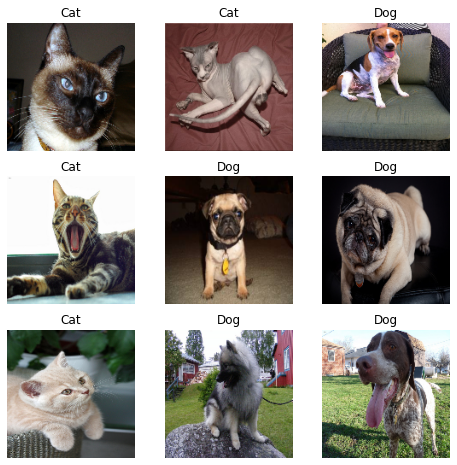

In [26]:
viz_data(train_data, species_map)

#### Create `DataLoader` objects for the training & validation data

In [27]:
# define the batch size
bs = 32

In [28]:
train_dataloader = DataLoader(train_data, batch_size=bs, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=bs, shuffle=True)

<a name="training-a-deep-neural-network-for-binary-classification"></a>

---
## Training a Deep Neural Network for Binary Classification

In this section we will be training a simple `Feed-Forward Neural Network` on our pets dataset.<br> The output of the network will be one of the 2 classes, i.e. `Cat` or `Dog`.

In [29]:
from functools import reduce

from torch.optim.sgd import SGD

In [165]:
class FeedForwardNetwork(nn.Module):
    """A class defining a simple Feedforward neural network"""

    def __init__(self, img_size):
        """Parameters:
        img_size - dimensions of the input image
        """
        super(FeedForwardNetwork, self).__init__()
        input_size = reduce(lambda x, y: x * y, img_size)

        self.sequential = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 512),
            # nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            # nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            # nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            # nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 16),
            # nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.sequential(x)

In [166]:
def train_loop(train_dataloader, model, loss_fn, optimizer, device="cpu"):
    """Function to perform the training on the data for one epoch.

    Parameters:
    train_dataloader (DataLoader) - dataloader object for the training data
    model - the model which has to be trained (& used for making predictions)
    loss_fn (function) - loss function to use for calculating the gradients
    optimizer - optimizer to use for updating the parameters of the model
    device (str: default="cpu") - device to use for training the model

    Returns: (tuple)
    Average of training loss taken across all the batches
    """
    model.train()
    avg_loss = 0
    for x, y in train_dataloader:
        x = x.float().to(device)
        y = y.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        pred = model(x)
        # Calculate loss & gradients
        loss = loss_fn(pred, y)
        avg_loss += loss.item()
        loss.backward()
        # Update parameter values
        optimizer.step()
    return avg_loss / len(train_dataloader)

In [167]:
def val_loop(val_dataloader, model, loss_fn, threshold=0.5, device="cpu"):
    """Function to calculate the loss & accuracy of the model for the validation
    dataset.

    Parameters:
    val_dataloader (DataLoader) - dataloader object for the validation data
    model - model for making the predictions
    loss_fn (function) - loss function to use for calculating the gradients
    threshold (float: default=0.5) - threshold value above which the prediction
                                    will be classified as belonging to class `1`
    device (str: default="cpu") - device to use for inference

    Returns: (tuple)
    Average of validation loss (taken across all the batches) & accuracy of the
    model,
    i.e. tuple of format (average loss, accuracy)
    """
    model.eval()
    avg_loss = 0
    correct = 0
    # Gradient need not be computed for the validation data, hence, computations
    # can be sped up
    with torch.no_grad():
        for x, y in val_dataloader:
            x = x.float().to(device)
            y = y.float().unsqueeze(1).to(device)
            pred = model(x)
            avg_loss += loss_fn(pred, y).item()
            correct += ((pred > threshold) == y).float().sum().item()
    return avg_loss / len(val_dataloader), correct / len(val_dataloader.dataset)

### Create, train & validate model

##### Use `GPU` for training if available else use `CPU`

In [168]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device being used: {device}")

Device being used: cuda


In [169]:
model = FeedForwardNetwork(img_size)
model.to(device);

In [170]:
n_epochs = 15
lr = 1e-3
optimizer = SGD(model.parameters(), lr)
bce_loss = nn.BCELoss()

In [171]:
results = pd.DataFrame(
    [],
    columns=["Training Loss", "Validation Loss", "Accuracy"],
    index=pd.Index([], name="Epoch No."),
)
for i in range(n_epochs):
    train_loss = train_loop(train_dataloader, model, bce_loss, optimizer, device=device)
    val_loss, accuracy = val_loop(val_dataloader, model, bce_loss, device=device)
    print(f"{train_loss}\t{val_loss}\t{accuracy}")
    results.loc[i] = [train_loss, val_loss, accuracy]

0.6896997641610063	1.0321840617967688	0.5938775510204082
0.6354986979909565	1.0756591066070225	0.6122448979591837
0.6033407831969468	1.2797756842944934	0.6074829931972789
0.589533695222243	1.3099135225233824	0.64421768707483
0.5691449198385944	1.4311391341945399	0.6591836734693878
0.5457455295583477	1.4523324772067692	0.6326530612244898
0.5257260760535365	1.209157509000405	0.672108843537415
0.49963136227882426	1.1372048530889594	0.6251700680272109
0.472712146361237	1.0999101231927457	0.6578231292517007
0.4489697422022405	1.3851108376098715	0.6714285714285714
0.41867686063051224	1.2010592818260193	0.6761904761904762
0.4049915948315807	1.2933769018753716	0.6646258503401361
0.3798845434642356	1.1969277204378792	0.682312925170068
0.35923348067571287	1.3886653191369513	0.6374149659863946
0.3378887722349685	1.5631418798280798	0.5952380952380952


In [172]:
results

,Training Loss,Validation Loss,Accuracy
Epoch No.,,,
0,0.689700,1.032184,0.593878
1,0.635499,1.075659,0.612245
2,0.603341,1.279776,0.607483
3,0.589534,1.309914,0.644218
4,0.569145,1.431139,0.659184
5,0.545746,1.452332,0.632653
6,0.525726,1.209158,0.672109
7,0.499631,1.137205,0.625170
8,0.472712,1.099910,0.657823


### Creating an Adversarial Example for the model

In [173]:
x, y = val_data[0]

In [174]:
species_map.get(y)

'Cat'

In [175]:
x_new = x.detach().clone().float().requires_grad_()

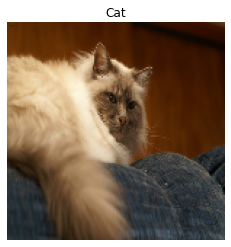

In [176]:
plt.figure()
plt.imshow(x_new.permute((1, 2, 0)).type(torch.uint8))
plt.axis("off")
plt.title(species_map.get(y))
plt.show()

In [177]:
y_new = 0 if y == 1 else 1

In [178]:
n_epochs = 10
lr = 1e-3

In [179]:
opt = SGD([x_new], lr, maximize=True)

In [180]:
x_new = x_new.unsqueeze(0).to(device)

In [181]:
model(x_new)

tensor([[0.2732]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
loss_func = nn.BCELoss()

In [182]:
for i in range(n_epochs):
    pred = model(x_new)
    opt.zero_grad()
    loss = loss_func(pred, y_new)
    opt.step()

In [182]:
model(x_new)